In [134]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import timeit

## Auxillary Functions


In [135]:
def getCrossProduct(p0,p1,p2):
    """
        Given 3 points, it returns the cross-product
        The cross-product lets us know whether the three points are collinear or whether 1 point is more (counter)clockwise from the other point
    """
    cross_product = (p1[0] - p0[0]) * (p2[1]-p0[1]) - (p2[0]-p0[0]) * (p1[1]-p0[1])

    if cross_product == 0:
        return 0 #p1
    elif cross_product > 0:
        return 1 #p2
    else:
        return -1 #p1

In [136]:
def findFurthest(origin, points):
    """
        Finds the squared distance between points in the "points" list relative to the origin. 
        Returns the point which is furthest away from the origin
    """
    def distance(point):
        return math.sqrt((origin[0] - point[0]) ** 2 + (origin[1] - point[1]) ** 2)
    
    return max(points, key=distance, default=None)

In [137]:
def binarySearch(subHull, curPoint):
    """
    Performs binary search on a subhull to find the point that is tangent to the convex hull.

    Parameters:
        subHull (list): The subhull to perform binary search on.
        curPoint: The current point to compare against the subhull.

    Returns:
        The point that is tangent to the convex hull.

    """

    hullSize = len(subHull)

    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    # stepSize = max(hullSize >> 1, 1)
    stepSize = hullSize >> 1
    if stepSize == 0:
        stepSize = 1

    while True:
        pointerChanged = False
        # stepSize = max(stepSize >> 1, 1)
        if stepSize != 1:
            stepSize >>= 1

        for operation in [+1, -1]:
            nextPointer = (pointer + operation) % hullSize

            cp = getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer])
            if cp < 0:
                pointer = (pointer + (stepSize * operation)) % hullSize
                pointerChanged = True
                break
            elif cp == 0:
                if curPoint == subHull[nextPointer]:
                    oppositePointer = (nextPointer + (operation)) % hullSize
                    cp = getCrossProduct(curPoint, subHull[pointer], subHull[oppositePointer])
                    if cp < 0:
                        return subHull[oppositePointer]
                    else:
                        return subHull[pointer]
                else:
                    nextNextPointer = (nextPointer + operation) % hullSize
                    if (getCrossProduct(curPoint, subHull[nextPointer], subHull[nextNextPointer])> 0):
                        return findFurthest(curPoint, [subHull[pointer], subHull[nextPointer]])

        if not pointerChanged:
            return subHull[pointer]


## Convex Hull Finding Algorithms


In [138]:
def jarvis(inputSet):
    """
    Computes the convex hull of a set of points using the Jarvis algorithm.

    Parameters:
        inputSet (list): A list of 2D points represented as tuples.

    Returns:
        list: A list of points that form the convex hull.

    """
    outputSet = []
    if len(inputSet) < 3: # Since anything less than these number of points can't create a convex hull
        return inputSet

    # Find the leftmost point
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    curPoint = firstPoint
    nextPoint = None

    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        nextPoint = inputSet[0] if inputSet[0] != curPoint else inputSet[1]

        # Iterate through all points in the inputSet to find the rightmost point relative to the current point
        for testPoint in inputSet:

            if testPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)

            if crossProduct > 0: # If the point being tested if more anticlockwise relative to the current point
                nextPoint = testPoint

            elif crossProduct == 0: # If all 3 points are collinear
                nextPoint = findFurthest(curPoint, [nextPoint, testPoint])
            
        curPoint = nextPoint
    return outputSet

In [139]:
def grahamScan(inputSet):
    """
    Implements the Graham's scan algorithm to compute the convex hull of a set of points.

    Parameters:
        inputSet (list): A list of 2D points represented as tuples (x, y).

    Returns:
        list: A list of points that form the convex hull.

    """

    pointAnglesDict = {} # Stores points in a list according to their angles - Points with the same angle will be appended to the list
    firstPoint = min(inputSet, key=lambda p: (p[1], p[0])) # Get the lowest and leftmost point
    outputSet = [firstPoint]

    # Calculate the polar angle for each point in the inputSet
    for point in inputSet:
        if point == firstPoint:
            continue
        
        angle_rad = math.atan2(point[1] - firstPoint[1], point[0] - firstPoint[0] )

        if angle_rad in pointAnglesDict:
            pointAnglesDict[angle_rad].append(point)
        else:
            pointAnglesDict[angle_rad] = [point]

    # Sort the points by their angles
    sortedPointAngles = sorted(list(pointAnglesDict.items()))

    point = None
    
    for pointDict in sortedPointAngles: # Iterate through all the points in order of their polar angle
        # Checks whether there are more than one point with the same angle. If there is, the furthest is taken
        if len(pointDict[1]) > 1:
            point = findFurthest(firstPoint, pointDict[1])
        else:
            point = pointDict[1][0]

        # Removes points before the newest point to be added until it a convex is formed. Any points between that causes a concave will be removed
        while len(outputSet) >= 2 and getCrossProduct(outputSet[-2], outputSet[-1], point) <= 0:
            outputSet.pop()  # Remove the last point in the outputSet because it makes a non-left turn
        outputSet.append(point)

    return outputSet

Following are the "dynamic" Chan's algorithm. This is what was mentioned in his paper. The group size (m) is found dynamically - meaning that if m is not greater than or equal to the number of hull points (h), then the m is doubled. The final hull points are returned when m >= h


In [140]:
def dynamicBinaryChan(inputSet):
    """
    Computes the convex hull of a given set of points using the Dynamic Binary Chan algorithm.

    Parameters:
        inputSet (list): A list of 2D points represented as tuples (x, y).

    Returns:
        list: A list of points representing the convex hull of the input.

    """
    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamScan(subset) for subset in subsets]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)
            rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
            nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

            for rightPoint in rightPoints:
                if rightPoint == curPoint:
                    continue

                crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
                if crossProduct < 0:
                    nextPoint = rightPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,rightPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet
            

In [141]:
def dynamicLinearChan(inputSet):
    """
    Computes the convex hull of a given input set using the Dynamic Linear Chan algorithm.

    Parameters:
    inputSet (list): A list of 2D points representing the input set.

    Returns:
    list: A list of points representing the convex hull of the input.
    """

    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamScan(subset) for subset in subsets]
        allSubHullPoints = [point for subHull in subHulls for point in subHull]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)

            nextPoint = allSubHullPoints[0] if allSubHullPoints[0] != curPoint else allSubHullPoints[1]

            for testPoint in allSubHullPoints:
                if testPoint == curPoint:
                    continue
                crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)
                if crossProduct < 0:
                    nextPoint = testPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,testPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet

Following are the "optimised" Chan's algorithm. We found that m=h did not give optimal results and hence why also implemented Chan's with a predicted optimal group size (m) given the size of the input set.


In [142]:
def optLinearChan(inputSet, groupSize):
  """
  Computes the convex hull of a given input set using the Optimal Linear Chan algorithm.

  Parameters:
  inputSet (list): The input set of points.
  groupSize (int): The size of each group of points.

  Returns:
  list: The convex hull of the input set.
  """
  outputSet = []
  
  subPoints = [inputSet[i:i + groupSize] for i in range(0, len(inputSet), groupSize)]
  subHulls = [grahamScan(points) for points in subPoints]
  allSubHullPoints = [point for subHull in subHulls for point in subHull]

  outputSet = jarvis(allSubHullPoints)

  return outputSet


In [143]:
def optBinaryChan(inputSet, groupSize=-1):
    """
    Computes the convex hull of a given input set using the optimized binary Chan algorithm.

    Parameters:
        inputSet (list): The input set of points.
        groupSize (int, optional): The size of each subset. If not provided, it is calculated as the ceiling of the square root of the input set size.

    Returns:
        list: The points that form the convex hull of the input.
    """

    hullSize = len(inputSet)

    if groupSize == -1:
        groupSize = math.ceil(math.sqrt(hullSize))

    subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
    outputSet = []
    subHulls = [grahamScan(subset) for subset in subsets]

    firstPoint = min(inputSet, key=lambda p: (p[1], p[0]))
    curPoint = firstPoint
    nextPoint = None
    
    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
        nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

        for rightPoint in rightPoints:
            if rightPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
            if crossProduct < 0:
                nextPoint = rightPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, rightPoint])

        curPoint = nextPoint
    return outputSet


In [144]:
def getGroupSize(inputSize):
    """
        These are the optimal group size values that were found through experimentation.
    """

    if inputSize >= 100000:
        return 2000
    elif inputSize >= 10000:
        return math.ceil(0.13 * inputSize + 728)
    elif inputSize >= 5000:
        return math.ceil(inputSize / 7)
    elif inputSize >= 1000:
        return 700
    elif inputSize >= 500:
        return math.ceil(inputSize / 3)
    elif inputSize >= 100:
        return math.ceil(inputSize / 2)
    else:
        return math.ceil(inputSize / 3)
        

## Test Data Generator


In [145]:
class TestDataGenerator(): #A class to represent a synthetic data generator.
    def __init__(self, minRange, maxRange):
        
        self.minRange = minRange
        self.maxRange = maxRange
        self.radius = (maxRange-minRange) // 2
        self.center=(self.radius, self.radius)
        self.points = [] # This is to store 1 test case - points are (x,y) tuples
        self.dataSet = [] # This stores multiple test cases


    def generateRandomUniform(self, size : int):
        """
        Generates a list of random points through uniform distribution in each axis.

        Parameters:
            size (int): The number of points to generate.

        Returns:
            list[(int,int)]: A list of (x, y) coordinates representing the generated points.
        """
        self.points = []
        while len(self.points) < size:
            xp = random.randint(self.minRange, self.maxRange)
            yp = random.randint(self.minRange, self.maxRange)
            self.points.append((xp,yp))
        return self.points


    def generateDenseCluster(self, size: int):
        """
        Generates a dense cluster of points using a uniform distribution for the angle and distance (relative to the center) using a normal distribution. 

        Parameters:
            size (int): The number of points to generate.

        Returns:
            list[(int,int)]: A list of (x, y) coordinates representing the generated points.
        """
        mu = 0 # This is the expected value for the normal distribution
        sigma = self.radius // 3 # This is the standard deviation for the normal distribution
        self.points = []

        while len(self.points) < size:
            theta = random.uniform(0, 2 * math.pi)
            
            # Generate a magnitude r with normal distribution
            r = random.normalvariate(mu, sigma)
            
            # Convert polar angles and distances to Cartesian coordinates
            x = math.ceil(r * math.cos(theta) + self.center[0])
            y = math.ceil(r * math.sin(theta) + self.center[1])
            
            # Ensures that the points generated are within the range specified
            x = max(min(x, 32767), 0) 
            y = max(min(y, 32767), 0)
            
            self.points.append((x, y))
        return self.points


    def generateHorizontalLine(self, size : int):
        """
        Generates a list of points representing a horizontal line.

        Parameters:
            size (int): The number of points to generate.

        Returns:
            list[(int,int)]: A list of (x, y) coordinates representing the generated points.
        """
        self.points = []
        while len(self.points) < size:
            xp = random.randint(self.minRange, self.maxRange)
            self.points.append((xp,0))
        return self.points


    def generateAllPointsOnHull(self, size: int):
        """
        Generates all points on the convex hull.

        Parameters:
            size (int): The number of points to generate. This does not always generate the exact amount of points are wanted.
        """
        self.points = []

        for i in range(size):
            angle = 2 * math.pi * i / size 
            x = int(self.center[0] + self.radius * math.cos(angle))
            y = int(self.center[1] + self.radius * math.sin(angle))
            self.points.append((x, y))

        random.shuffle(self.points) # Shuffles the points to ensure Graham Scan is not given bias with an already sorted list


    def fillHull(self, numTotalPoints: int):
        """
        Fills the hull with random points until the number of points reaches numTotalPoints.

        Parameters:
            numTotalPoints (int): The desired number of points in the hull.
        """
        while len(self.points) < numTotalPoints:
            angle = random.uniform(0, 2 * math.pi)
            dist = random.uniform(0, self.radius - 2000)

            x = int(self.center[0] + dist * math.cos(angle))
            y = int(self.center[1] + dist * math.sin(angle))
            self.points.append((x, y))


    def generatePointsGivenNincreasingH(self, numTotalPoints: int, numCases: int, minStartSize: int):
        """
        Generates a set of points on a convex hull with increasing size.

        Parameters:
            numTotalPoints (int): The total number of points to generate.
            numCases (int): The number of cases to generate.
            minStartSize (int, optional): The minimum size of the starting convex hull.

        Returns:
            list[int]: A list of hull sizes for each case.

        """
        self.dataSet = []
        hValues = []
        prevHullSize = minStartSize
        i = 3
        for _ in range(numCases):
            while True:
                self.generateAllPointsOnHull(2**i) 

                # Calculate the hull to find the actual number of points that lie on the convex hull
                actualHull = grahamScan(self.points)
                actualHullSize = len(actualHull)
                if actualHullSize > numTotalPoints: # Stops generating points if the number of points on the hull is greater than the total points there should be
                    return hValues
                
                if actualHullSize > prevHullSize: # Ensure that the number of points on the hull is not less than or equal to previous iteration
                    self.points = actualHull
                    self.fillHull(numTotalPoints) # Filling the hull with rest of points
                    hValues.append(actualHullSize)
                    self.dataSet.append(self.points)
                    prevHullSize = actualHullSize
                    i += 1
                    break
                else:
                    i += 1

        return hValues


    def generateAllHullDataset(self, minNumPoints: int, maxNumPoints: int):
        """
        Generates a dataset of convex hulls with varying number of points.

        Parameters:
            minNumPoints (int): The minimum number of points in the convex hull.
            maxNumPoints (int): The maximum number of points in the convex hull.

        Returns:
            list[int]: A list of hull sizes for each generated convex hull.

        """
        self.dataSet = []
        hValues = []
        prevHullSize = minNumPoints
        i = 3
        while True:
            self.generateAllPointsOnHull(2**i)
            actualHull = grahamScan(self.points)
            actualHullSize = len(actualHull)
            if actualHullSize > prevHullSize:
                self.dataSet.append(actualHull)
                prevHullSize = actualHullSize
                hValues.append(actualHullSize)

            i += 1

            if actualHullSize >= maxNumPoints:
                break
        return hValues

## Experimental Framework


In [146]:
class ExperimentalFramework():
    """
    A class to represent an experimental framework. Designed to generate and plot test results from various test cases.

    """
    
    def __init__(self, minRange: int, maxRange: int):
        self.minRange = minRange
        self.maxRange = maxRange
        self.testGen = TestDataGenerator(minRange, maxRange)

        #Lists to store convex hull points generated from the respective algorithms
        self.jarvisBorder = []
        self.grahamBorder = []
        self.optLinearChanBorder = []
        self.optBinaryChanBorder = []
        self.dynLinearChanBorder = []
        self.dynBinaryChanBorder = []

        # Labels for graphs
        self.legendLabels = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)"]
        self.legendLabelsWithDynamic = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)", "Chan (Linear, Dynamic)", "Chan (Binary, Dynamic)"]
        

    # Run algorithms and return execution time
        
    def runJarvis(self, inputSet):
        start = timeit.default_timer()
        self.jarvisBorder = jarvis(inputSet)
        end = timeit.default_timer()
        return (end - start)
    

    def runGraham(self, inputSet):
        start = timeit.default_timer()
        self.grahamBorder = grahamScan(inputSet)
        end = timeit.default_timer()
        return (end - start)


    def runOptBinaryChan(self, inputSet, groupSize=-1):
        if groupSize == -1:
            groupSize = getGroupSize(len(inputSet))
        
        start = timeit.default_timer()
        self.optBinaryChanBorder = optBinaryChan(inputSet, groupSize)
        end = timeit.default_timer()
        return (end - start)
    

    def runOptLinearChan(self, inputSet, groupSize=-1): 
        if groupSize == -1:
            groupSize = getGroupSize(len(inputSet))
        
        start = timeit.default_timer()
        self.optLinearChanBorder = optLinearChan(inputSet, groupSize)
        end = timeit.default_timer()
        return (end - start)
    

    def runDynBinaryChan(self, inputSet):
        start = timeit.default_timer()
        self.dynBinaryChanBorder = dynamicBinaryChan(inputSet)
        end = timeit.default_timer()
        return (end - start)
    

    def runDynLinearChan(self, inputSet):
        start = timeit.default_timer()
        self.dynLinearChanBorder = dynamicLinearChan(inputSet)
        end = timeit.default_timer()
        return (end - start)
    

    # Utility Functions
    def plotPoints(self, points):
        margin = 5000
        xPoints, yPoints = zip(*points)
        plt.scatter(xPoints, yPoints, color='red', s=1)

        # plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        # plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()


    def drawHull(self, points, hullPoints):
        margin = 50
        xPoints, yPoints = zip(*points)
        tempLines = hullPoints + [hullPoints[0]]
        xLine, yLine = zip(*tempLines)
        plt.scatter(xPoints, yPoints, color='red', s=3)
        plt.plot(xLine, yLine, '-', color='blue')

        # plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        # plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    

    def plotResults(self, xTitle, xValues, legendLabels, yTitle, yValueList, title="", vertLineCoord=None):
        plt.figure(figsize=(8,6))

        for i, yValues in enumerate(yValueList):
            plt.plot(xValues, yValues, 'o-', label=legendLabels[i])
        plt.title(title)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.grid(True)

        if vertLineCoord is not None:
            plt.axvline(x=vertLineCoord, color = 'r')

        plt.legend()

        plt.tight_layout()
        plt.show()


    def stressTest(self, sizes, repeats):
        """
        Perform a stress test on the convex hull algorithms.

        Parameters:
            repeats (int): The number of times to repeat the test for each size. Repeats in this case uses different test cases for each iteration.
            sizes (list[int]): A list of sizes to test.

        Returns:
            An integer containing the number of wrong tests and a list of the wrong tests.

        """
        wrongCount = 0
        wrongTests = []

        for size in sizes:
            print("\nCurrent Size:", size)
            for _ in range(repeats):
                self.testGen.generateRandomUniform(size)
                
                self.runJarvis(self.testGen.points)
                self.runGraham(self.testGen.points)
                self.runOptLinearChan(self.testGen.points)
                self.runOptBinaryChan(self.testGen.points)
                self.runDynLinearChan(self.testGen.points)
                self.runDynBinaryChan(self.testGen.points)

                self.jarvisBorder.sort()
                self.grahamBorder.sort()
                self.optLinearChanBorder.sort()
                self.optBinaryChanBorder.sort()
                self.dynBinaryChanBorder.sort()
                self.dynLinearChanBorder.sort()

                if not (self.jarvisBorder == self.grahamBorder == self.optLinearChanBorder == self.optBinaryChanBorder == self.dynBinaryChanBorder == self.dynLinearChanBorder):
                    wrongTests.append(self.testGen.points)
                    wrongCount += 1
                    print("New Error, Current Count:", wrongCount)

            print("Wrong So Far:", wrongCount)
        return wrongCount, wrongTests
    

    def compareAverage(self, inputSizes, testType, repeats=5, withDynamicChan=False):
        """
        Compare the average performance of different algorithms for computing the convex hull.

        Parameters:
            inputSizes (list[int]): A list of input sizes to test.
            testType (int): The type of test to perform. 0 for random points, 1 for dense cluster.
            repeats (int, optional): The number of times to repeat each test. Defaults to 5.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False.
        """

        # Test Type - 0 : Random, 1 : Dense Cluster
        titles = ["Random", "Dense Cluster"]

        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                if testType == 0:
                    self.testGen.generateRandomUniform(inputSize)
                elif testType == 1:
                    self.testGen.generateDenseCluster(inputSize)

                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])

        self.plotResults("Input Size", inputSizes, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : " + titles[testType])


    def compareAllOnHull(self, minHullSize, maxHullSize, repeats=5, withDynamicChan=False):
        """
        Compare the performance of different algorithms on a dataset where all points are on the convex hull by plotting a graph of Number of Points on Hull against time taken.

        Parameters:
            minHullSize (int): The minimum number of points on the convex hull.
            maxHullSize (int): The maximum number of points on the convex hull.
            repeats (int, optional): The number of times to repeat each test. Defaults to 5.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False.
        """

        hValues = self.testGen.generateAllHullDataset(minHullSize, maxHullSize)
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])

        self.plotResults("Number of Points on Hull (N=h)", hValues,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : All on Hull")


    def compareNtoHRatio(self, numTotalPoints, numCases, repeats=5, withDynamicChan=False, minStartSize=3):
        """
        Compare the performance of different convex hull algorithms based on the ratio of the number of points to the number of points on the hull by plotting a graph of Number of Points on Hull against time taken for a given N.

        Parameters:
            numTotalPoints (int): The total number of points to generate.
            numCases (int): The number of test cases to run.
            repeats (int, optional): The number of times to repeat each test. Defaults to 5.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False.
            minStartSize (int, optional): The minimum size of the starting set of points. Defaults to 3.
        """
        hValues = self.testGen.generatePointsGivenNincreasingH(numTotalPoints, numCases, minStartSize)
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))
                
            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Number of Points on Hull", hValues, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : N to h Ratio (" + str(numTotalPoints)+" Total Points)")


    def compareCollinear(self, inputSizes, repeats=5, withDynamicChan=False):
        """
        Compares All Algorithms for the case where All points are collinear and Plots a Graph of Input Size against Time Taken

        Parameters:
            inputSizes (list[int]): A list of input sizes to test the algorithms with.
            repeats (int, optional): The number of times to repeat each algorithm for each input size. Defaults to 5.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False
        """

        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            self.testGen.generateHorizontalLine(inputSize)
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Input Size", inputSizes,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : Collinear Points")


    def findingChanOptimalGroupSize(self, inputSize, groupSizes, minHullPoints, repeats=5):
        """
        Tests a given data set across a range of group sizes (m). This will allow us to find trends in the performance of Chan's algorithm
        depending on m.

        Parameters:
            inputSize (int): The size of the input.
            groupSizes (list[int]): A list of group sizes to test.
            minHullPoints (int): The minimum number of hull points.
            repeats (int, optional): The number of times to repeat each test. Defaults to 5.
        """

        results = []
        self.testGen.generatePointsGivenNincreasingH(inputSize, 1, minHullPoints)
        numHullPoints = 0
        
        for groupSize in groupSizes:
            time = []
            for i in range(repeats):
                time.append(self.runOptBinaryChan(self.testGen.points, groupSize))
            results.append(sorted(time)[math.ceil(repeats/2)])

        numHullPoints = len(self.optBinaryChanBorder)
        self.plotResults("Group Size", groupSizes, ["Data"], "Time Taken (s)", [results], "Chan - Finding Optimal Group Size N=" + str(inputSize)+", h="+str(numHullPoints), numHullPoints) #


In [147]:
fw = ExperimentalFramework(0, 32767)


Current Size: 3
Wrong So Far: 0

Current Size: 4
Wrong So Far: 0

Current Size: 5
Wrong So Far: 0

Current Size: 6
Wrong So Far: 0

Current Size: 7
Wrong So Far: 0

Current Size: 8
Wrong So Far: 0

Current Size: 9
Wrong So Far: 0

Current Size: 10
Wrong So Far: 0

Current Size: 11
Wrong So Far: 0

Current Size: 12
Wrong So Far: 0

Current Size: 13
Wrong So Far: 0

Current Size: 14
Wrong So Far: 0

Current Size: 15
Wrong So Far: 0

Current Size: 16
Wrong So Far: 0

Current Size: 17
Wrong So Far: 0

Current Size: 18
Wrong So Far: 0

Current Size: 19
Wrong So Far: 0


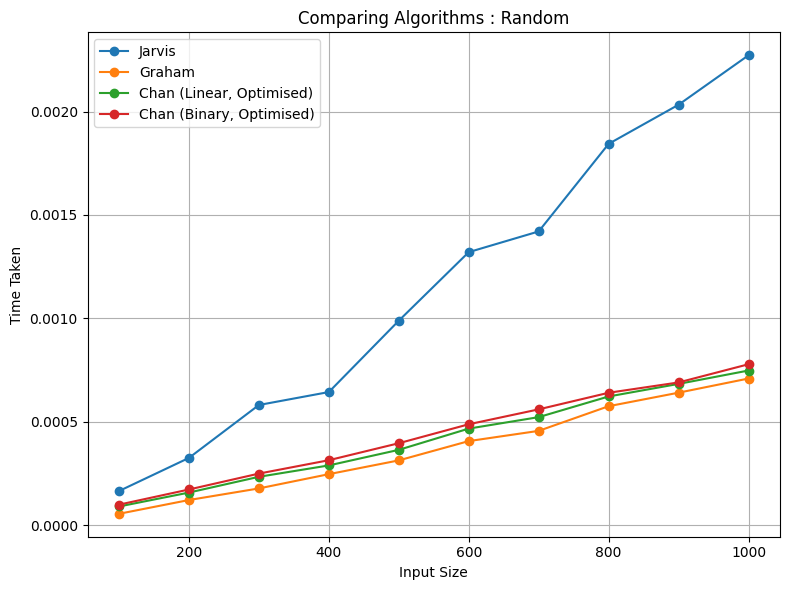

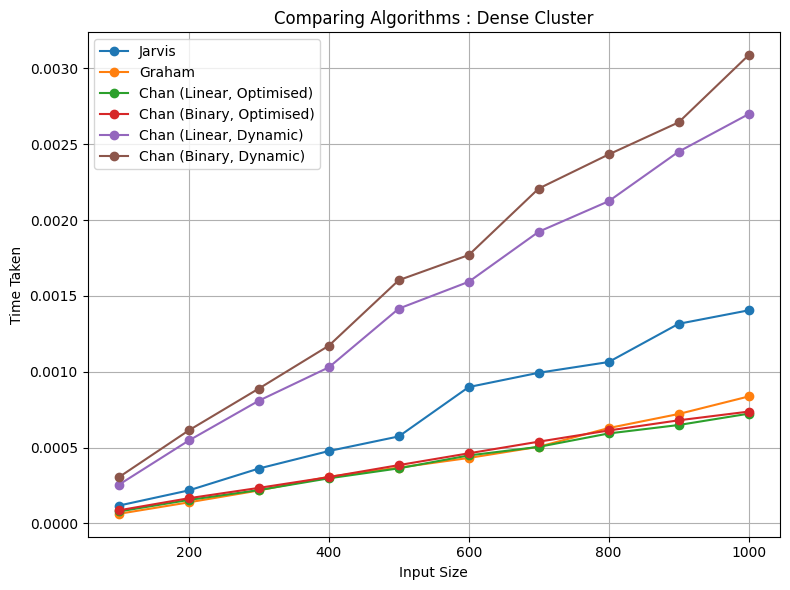

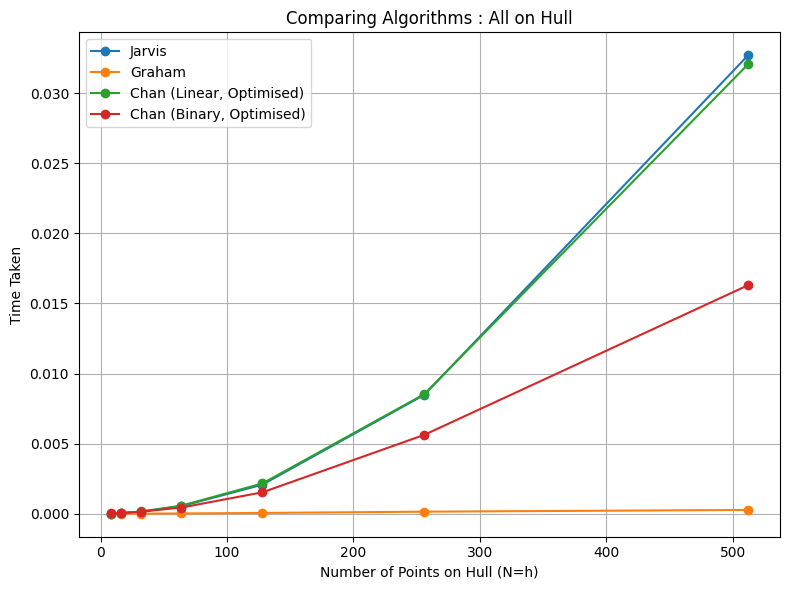

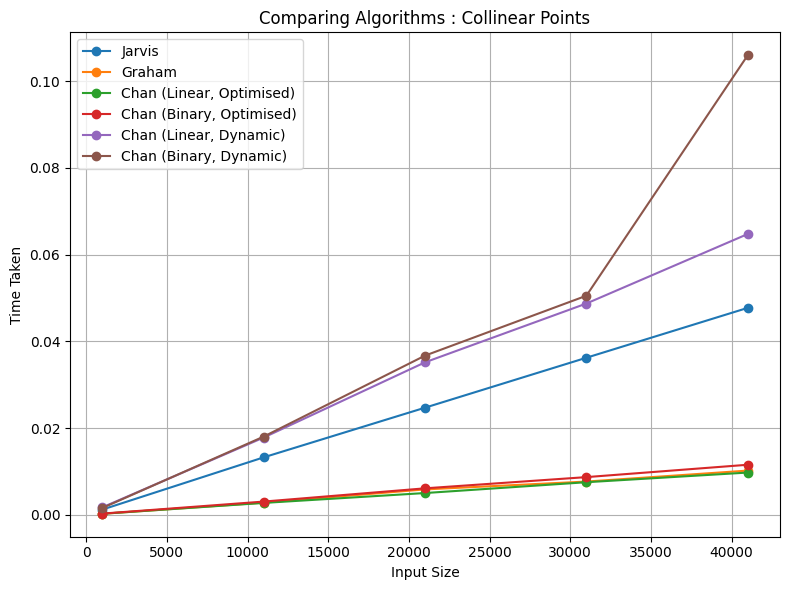

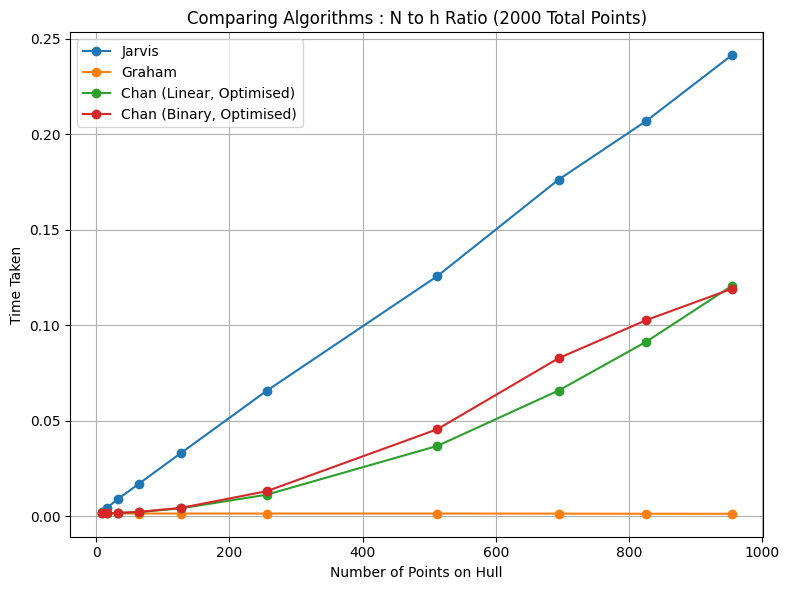

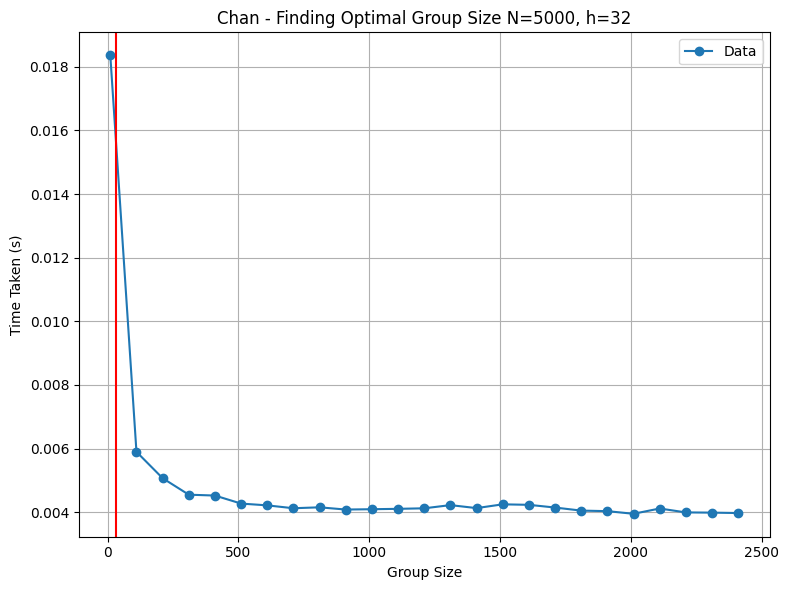

In [148]:
def sampleFrameworkUsage():
  fw.stressTest([i for i in range(3, 20)], 100) 
  fw.compareAverage([i for i in range(100, 1100, 100)], 0)
  fw.compareAverage([i for i in range(100, 1100, 100)], 1, withDynamicChan = True)
  fw.compareAllOnHull(3, 400)
  fw.compareCollinear([i for i in range(1000, 50000, 10000)], 5, True)
  fw.compareNtoHRatio(2000, 10)
  fw.findingChanOptimalGroupSize(5000, [i for i in range(10, 2500, 100)], 16)
sampleFrameworkUsage()

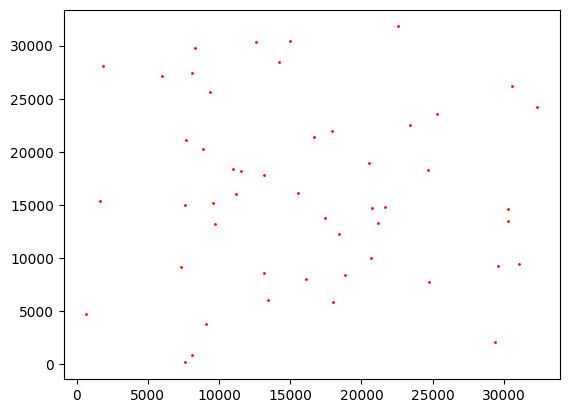

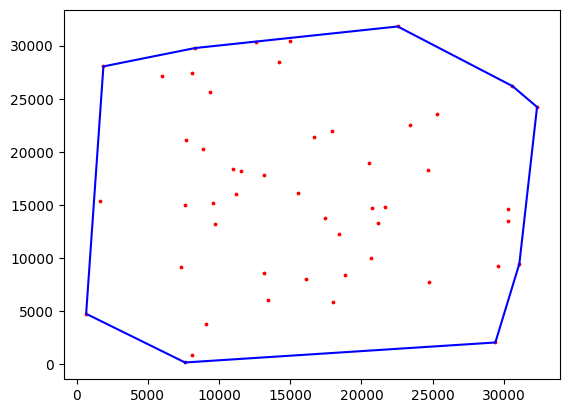

In [149]:
def visualiseHull():
  fw = ExperimentalFramework(0, 32767)
  gen = TestDataGenerator(0, 32767)
  points = gen.generateRandomUniform(50)
  fw.plotPoints(points)
  hullPoints = grahamScan(points)
  fw.drawHull(points, hullPoints)
visualiseHull()


